Zakupoholicy

Data: https://www.kaggle.com/datasets/benpowis/customer-propensity-to-purchase-data

Purpose: analysis of whether a given customer will make a purchase with us or not

Stakeholder: the owner of an online store trying to minimize the risk of shopping cart abandonment

Library import:

In [118]:
# modules for data import, preprocessing, visualisation, model optimation and evaluation
import logging
import kagglehub
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, make_scorer, accuracy_score, precision_score, f1_score, recall_score, roc_curve, roc_auc_score, auc 
# ML modelling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb
# warnings set
import warnings
warnings.filterwarnings("ignore")

**Dataset import with kagglehub**

In [50]:
# latest version data download in .csv format
path = kagglehub.dataset_download("benpowis/customer-propensity-to-purchase-data")
print("Path to dataset files:", path)

# BEWARE! data are already divided into training and test sets: training_sample.csv and test_sample.csv
df_train = pd.read_csv(r'C:\Users\marci\.cache\kagglehub\datasets\benpowis\customer-propensity-to-purchase-data\versions\3\training_sample.csv')
df_test = pd.read_csv(r'C:\Users\marci\.cache\kagglehub\datasets\benpowis\customer-propensity-to-purchase-data\versions\3\testing_sample.csv')

Path to dataset files: C:\Users\marci\.cache\kagglehub\datasets\benpowis\customer-propensity-to-purchase-data\versions\3


**Data preprocessing**

Looking on the distibution of target variable in both datasets:

In [51]:
print(f'Distibution of target variable in train set:\n {df_train['ordered'].value_counts(normalize=True)}','\n\n')
print(f'Distibution of target variable in test set:\n {df_test['ordered'].value_counts(normalize=True)}')

Distibution of target variable in train set:
 ordered
0    0.958074
1    0.041926
Name: proportion, dtype: float64 


Distibution of target variable in test set:
 ordered
0    1.0
Name: proportion, dtype: float64


As we can observe in test dataset, there are no occurances of positive class which does'nt make sense. To workaround this problem we'll merge both datasets into one for the purposes of further analysis. Firstly we need to verify if structure do both sets is the same:

In [52]:
# check of column names to make sure that we can concat train and test sets without any consequences
print(f'Train set column names: {df_train.columns}\nColumns number: {len(df_train.columns)}')
print(f'Test set column names: {df_test.columns}\nColumns number: {len(df_test.columns)}')
df_train.columns == df_test.columns

Train set column names: Index(['UserID', 'basket_icon_click', 'basket_add_list', 'basket_add_detail',
       'sort_by', 'image_picker', 'account_page_click', 'promo_banner_click',
       'detail_wishlist_add', 'list_size_dropdown', 'closed_minibasket_click',
       'checked_delivery_detail', 'checked_returns_detail', 'sign_in',
       'saw_checkout', 'saw_sizecharts', 'saw_delivery', 'saw_account_upgrade',
       'saw_homepage', 'device_mobile', 'device_computer', 'device_tablet',
       'returning_user', 'loc_uk', 'ordered'],
      dtype='object')
Columns number: 25
Test set column names: Index(['UserID', 'basket_icon_click', 'basket_add_list', 'basket_add_detail',
       'sort_by', 'image_picker', 'account_page_click', 'promo_banner_click',
       'detail_wishlist_add', 'list_size_dropdown', 'closed_minibasket_click',
       'checked_delivery_detail', 'checked_returns_detail', 'sign_in',
       'saw_checkout', 'saw_sizecharts', 'saw_delivery', 'saw_account_upgrade',
       'saw_homep

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

Structure is the same. Therefore, we can concat both sets without any additional transformations

In [53]:
# training and test sets concatenation
df = pd.concat([df_train,df_test], axis=0)

First look at our new data collection:

In [54]:
# glance at the head observations
df.head()

,UserID,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,...,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered
0,a720-6b732349-a720-4862-bd21-644732,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,a0c0-6b73247c-a0c0-4bd9-8baa-797356,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,86a8-6b735c67-86a8-407b-ba24-333055,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
3,6a3d-6b736346-6a3d-4085-934b-396834,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
4,b74a-6b737717-b74a-45c3-8c6a-421140,0,1,0,1,0,0,0,0,1,...,0,0,0,1,0,0,1,0,1,1


In [55]:
# glance at the tail observations
df.tail()

,UserID,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,...,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered
151650,d14b-520k-0j15d14b-520k-4kk2-660471,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,1,1,0
151651,d427-5450-0j15d427-5450-4661-370635,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
151652,8869-1022-0j168869-1022-4490-699568,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
151653,5893-2228-0j165893-2228-4kb7-871348,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
151654,64k0-8720-0j1664k0-8720-447k-692331,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,1,0


We need to know what our variables represent:
- basket_icon_click - Did the visitor click on the shopping basket icon?
- basket_add_list - Did the visitor add a product to their shopping cart on the 'list' page?
- basket_add_detail - Did the customer add a product to their shopping basket from the product detail page?
- sort_by - Did the visitor sort products on a page?
- image_picker - Did the visitor use the image picker?
- account_page_click - Did the visitor visit their account page?
- promo_banner_click - Did the visitor click on a promo banner?
- detail_wishlist_add - Did the visitor add a product to their wishlist from the 'detail' page?
- list_size_dropdown - Did the visitor interact with a product dropdown?
- closed_minibasket_click - Did the visitor close their mini shopping basket?
- checked_delivery_detail - Did the visitor view the delivery FAQ area on a product page?
- checked_returns_detail - Did the visitor check the returns FAQ area on a product page?
- sign_in - Did the customer sign in to the website?
- saw_checkout - Did the visitor view the checkout?
- saw_sizecharts - Did the visitor view a product size chart?
- saw_delivery - Did the visitor view the delivery FAQ page?
- saw_account_upgrade - Did the visitor view the account upgrade page?
- saw_homepage - Did the visitor view the website homepage?
- device_mobile - Was the visitor on a mobile device?
- device_computer - Was the visitor on a desktop device?
- device_tablet - Was the visitor on a table device?
- returning_user - Is this visitor new, or returning?
- loc_uk - Was the visitor located in the UK, based on their IP address?
- ordered - DEPENDENT VARIABLE - Did the customer place an order?

Data types check:

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607056 entries, 0 to 151654
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   UserID                   607056 non-null  object
 1   basket_icon_click        607056 non-null  int64 
 2   basket_add_list          607056 non-null  int64 
 3   basket_add_detail        607056 non-null  int64 
 4   sort_by                  607056 non-null  int64 
 5   image_picker             607056 non-null  int64 
 6   account_page_click       607056 non-null  int64 
 7   promo_banner_click       607056 non-null  int64 
 8   detail_wishlist_add      607056 non-null  int64 
 9   list_size_dropdown       607056 non-null  int64 
 10  closed_minibasket_click  607056 non-null  int64 
 11  checked_delivery_detail  607056 non-null  int64 
 12  checked_returns_detail   607056 non-null  int64 
 13  sign_in                  607056 non-null  int64 
 14  saw_checkout             

In [57]:
# column descriptions
df.describe()

,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,...,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered
count,607056.000000,607056.000000,607056.000000,607056.000000,607056.000000,607056.000000,607056.000000,607056.000000,607056.000000,607056.000000,...,607056.000000,607056.000000,607056.000000,607056.000000,607056.000000,607056.000000,607056.000000,607056.000000,607056.000000,607056.000000
mean,0.092924,0.071132,0.106053,0.036746,0.026385,0.003468,0.015700,0.003397,0.226770,0.016312,...,0.000366,0.005431,0.001071,0.288919,0.680891,0.195832,0.126287,0.533504,0.932000,0.031452
std,0.290326,0.257045,0.307905,0.188138,0.160277,0.058784,0.124314,0.058182,0.418743,0.126671,...,0.019120,0.073496,0.032705,0.453261,0.466132,0.396840,0.332172,0.498877,0.251747,0.174535
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Min and max values of variables indicate clearly that almost all of them have binary type. The only exception is UserID, which however is not pivotal for us in terms of modelling.

Let's look now if we have any missing data:

In [58]:
# looking for NaN values for each variable
df.isna().sum()

UserID                     0
basket_icon_click          0
basket_add_list            0
basket_add_detail          0
sort_by                    0
image_picker               0
account_page_click         0
promo_banner_click         0
detail_wishlist_add        0
list_size_dropdown         0
closed_minibasket_click    0
checked_delivery_detail    0
checked_returns_detail     0
sign_in                    0
saw_checkout               0
saw_sizecharts             0
saw_delivery               0
saw_account_upgrade        0
saw_homepage               0
device_mobile              0
device_computer            0
device_tablet              0
returning_user             0
loc_uk                     0
ordered                    0
dtype: int64

As we can see above there is no missing values in our dataset to cope with.

Duplicates check for UserID

In [59]:
# potential duplicates for UserID
duplicate_count = df['UserID'].duplicated().sum()
print(f'Number of duplicates for UserID: {duplicate_count}')

Number of duplicates for UserID: 0


There are no duplicates for UserID

**Descriptive statistics**

Descriptive statistics is a method used to summarize and describe the main features of a dataset, providing an overview of its distribution, central tendency, and variability. Key metrics include the mean (average), median (middle value), mode (most frequent value), standard deviation (measure of spread), and range (difference between the maximum and minimum values). These statistics help in understanding the structure of the data and identifying patterns, outliers, or potential issues. 

Since our dataset contains binary categorical variables, the descriptive statistics we need to consider are: the class frequency (including percentage), the mode, and the standard deviation:

In [60]:
# binary variables list
binary_feats = df.select_dtypes(include='int64').columns

# empty dict for basic categorical stats for binary variables
basic_cat_stats = {}

# loop calculating basic stats and assigning them in form of data frame into basic_cat_stats
for var in binary_feats:
    tmp_value_counts = df[var].value_counts()
    tmp_perc_of_occur = round(df[var].value_counts(normalize = True) * 100, 3)
    tmp_mode = df[var].mode()[0]
    
    basic_cat_stats[var] = pd.DataFrame({
        'Value Counts': tmp_value_counts,
        'Percentage of occurances': tmp_perc_of_occur,
        'Mode': [tmp_mode] * len(tmp_value_counts)
    })

# glance at the results
for var, stats in basic_cat_stats.items():
    print(f'Basic statistics for {var.upper()}:\n')
    print(stats,'\n','-'*80)

Basic statistics for BASKET_ICON_CLICK:

                   Value Counts  Percentage of occurances  Mode
basket_icon_click                                              
0                        550646                    90.708     0
1                         56410                     9.292     0 
 --------------------------------------------------------------------------------
Basic statistics for BASKET_ADD_LIST:

                 Value Counts  Percentage of occurances  Mode
basket_add_list                                              
0                      563875                    92.887     0
1                       43181                     7.113     0 
 --------------------------------------------------------------------------------
Basic statistics for BASKET_ADD_DETAIL:

                   Value Counts  Percentage of occurances  Mode
basket_add_detail                                              
0                        542676                    89.395     0
1                

We can plot those results to ease an interpretation:

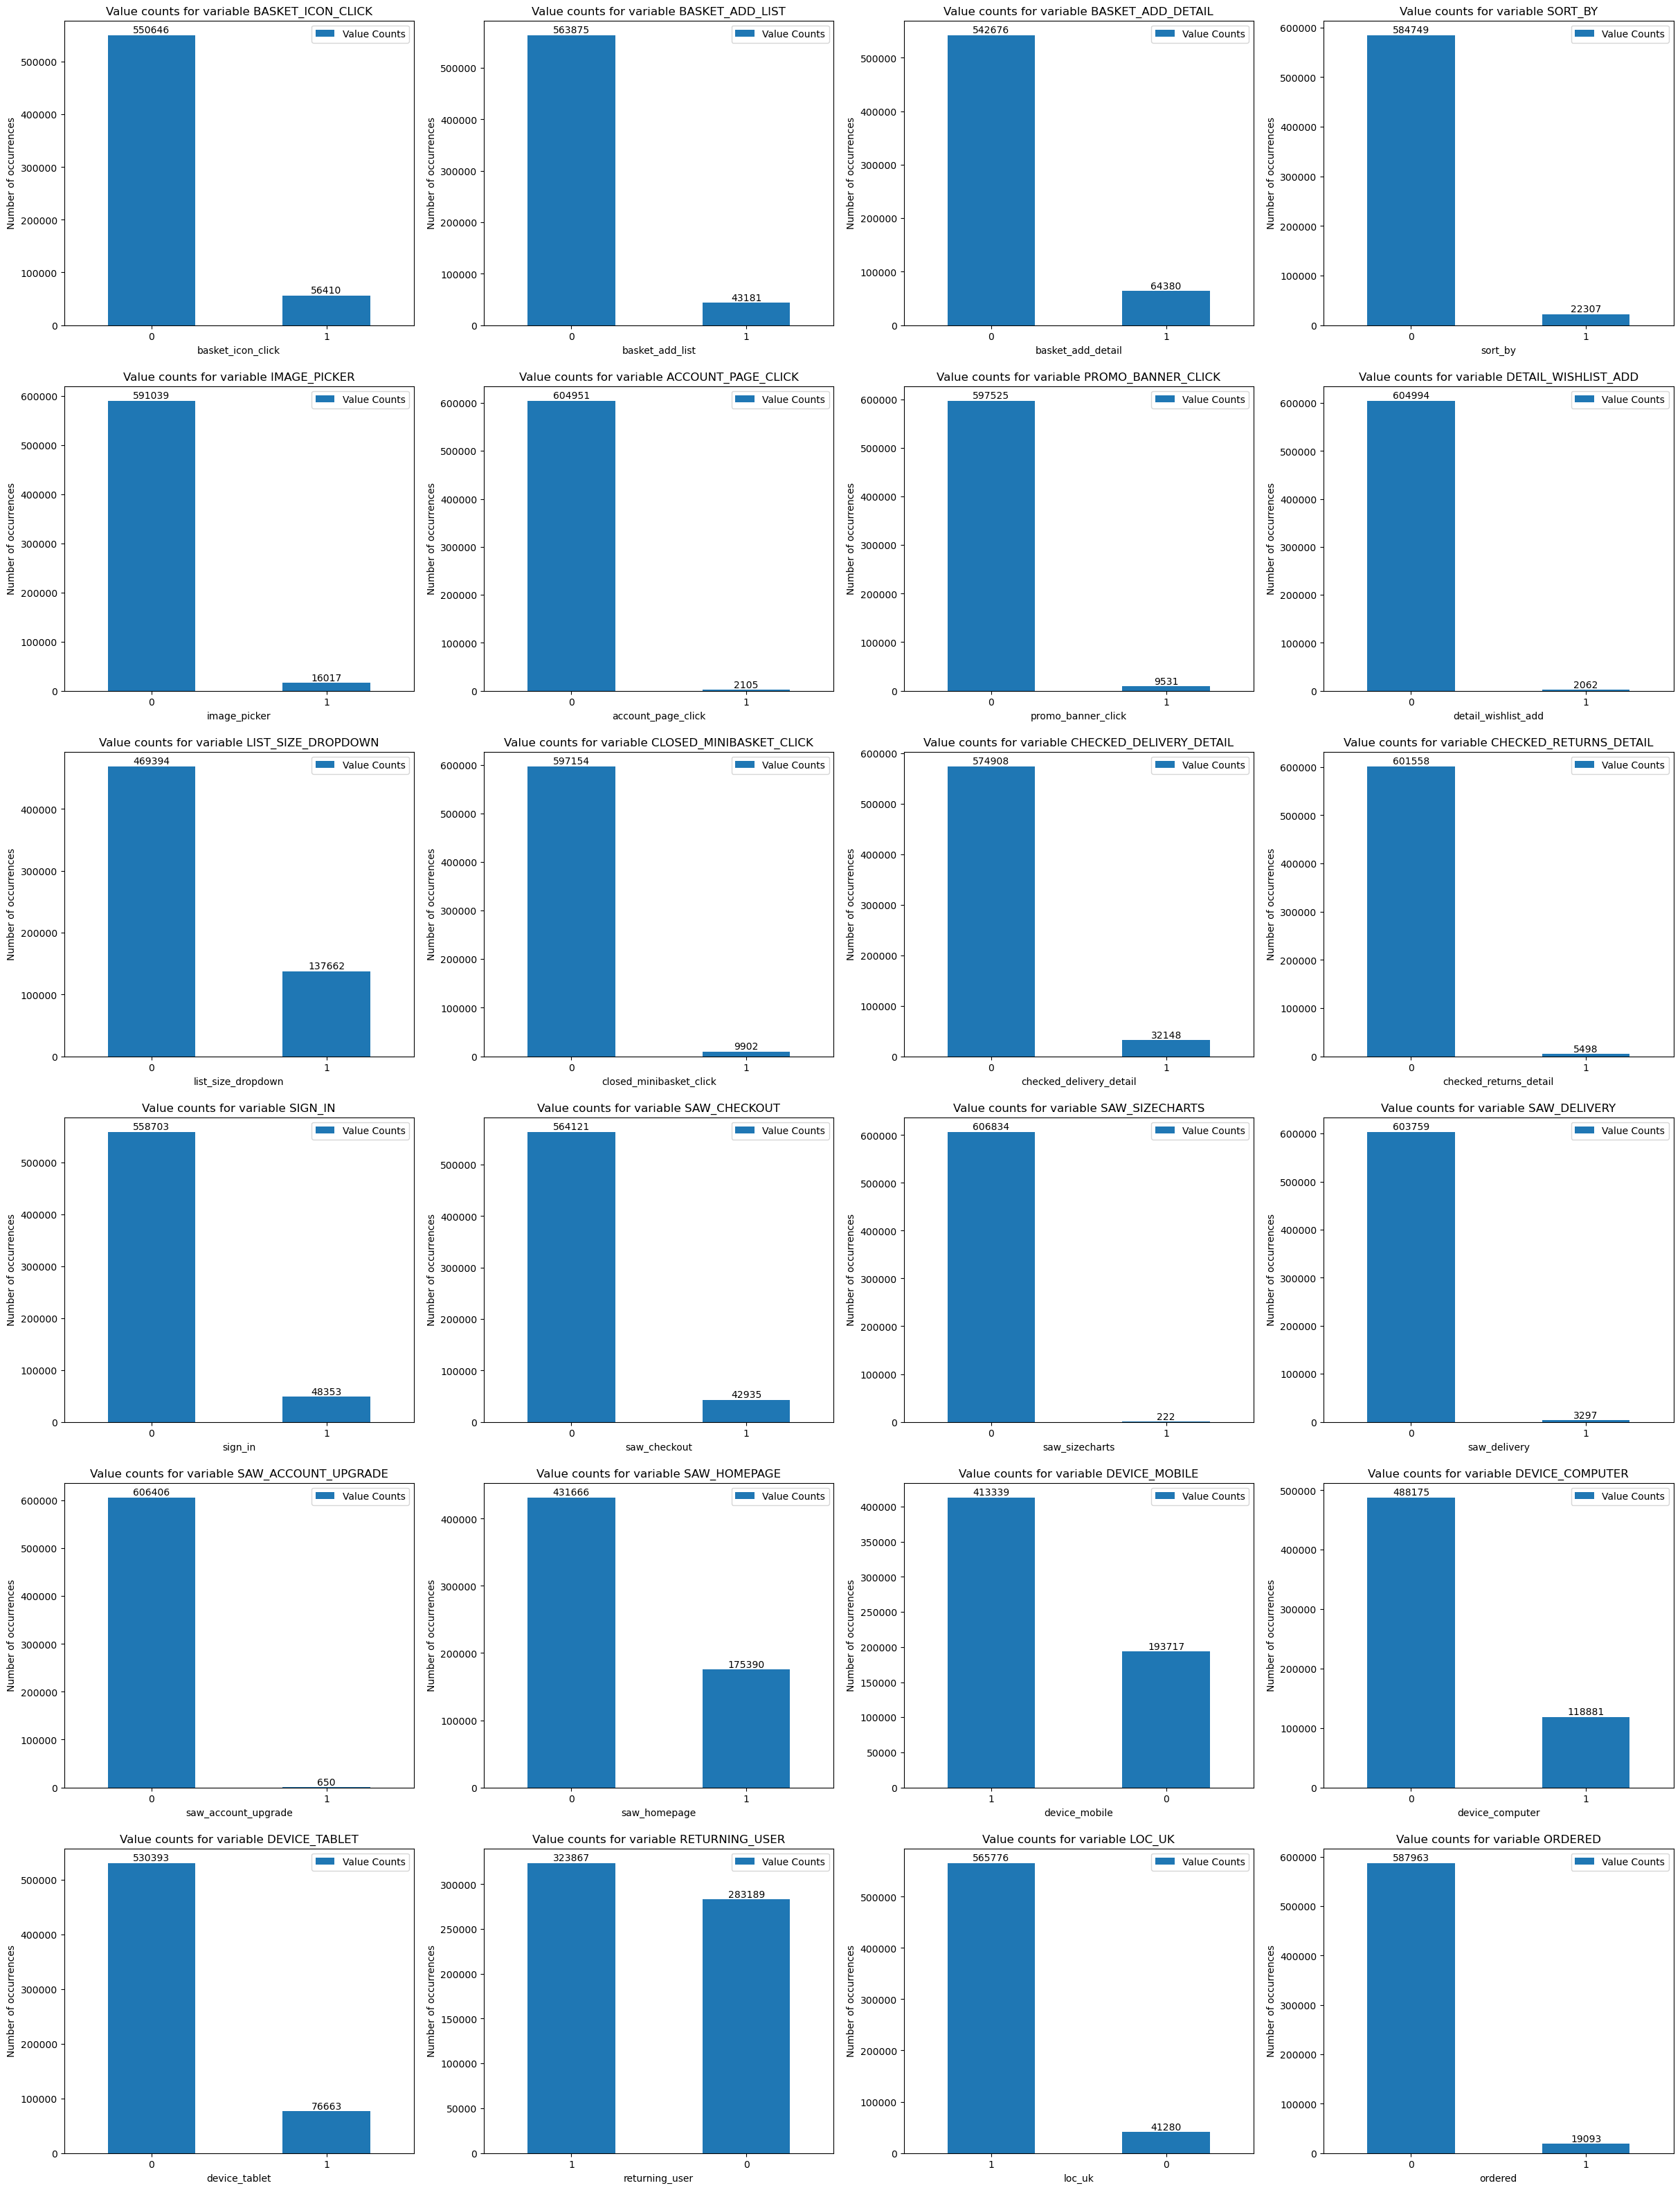

In [61]:
# Number of rows and columns in the grid
n_cols = 4  # Number of columns in the grid
n_rows = math.ceil(len(basic_cat_stats.keys()) / n_cols)  # Proper ceiling division for rows

# Set up the grid
fig, axes = plt.subplots(n_rows, n_cols)

# Flatten axes to make it easier to index
axes = axes.flatten()

# Loop to plot value counts for each binary variable
for i, var in enumerate(basic_cat_stats.keys()):
    # Temporary DataFrame
    tmp_df = pd.DataFrame(basic_cat_stats[var]['Value Counts'].reset_index().set_index(var))
    
    # Create bar plot
    tmp_df.plot(
        kind='bar',
        ax=axes[i],
        figsize=(30, 40),
        title=f'Value counts for variable {var.upper()}',
        ylabel='Number of occurrences',
        legend=True,
        rot=0  # Changing x ticks orientation to horizontal
    )
    
    # Adding labels to the chart
    axes[i].bar_label(axes[i].containers[0], label_type='edge')

# Hide unused subplots
for j in range(len(basic_cat_stats.keys()), len(axes)):
    fig.delaxes(axes[j])

# Show the grid
plt.show()

All of the variables exhibit a significant imbalance in the frequency of their categories.

What seems the most problematic is huge imbalance of target variable ORDERED which could bias prediction of our model. In short our classifier could be more inclined to classify new data into the more numerous class 0, thus perform poorly on class 1. Most likely we will have to undersample majority class 0 with methods like Random Undersampling, TomekLinks or oversample minority class 1 with methods like Random Oversampling, SMOTE, ADASYN or use combined approach with SMOTE-Tomek method.

Let's calculate variance of each feature, measured by standard deviation (we can get this information by using transposed describe() function, but let's calculate it on our own). If their scores are very low, most likely we'll have to remove them from our dataset (they don't provide any useful information for our model).

In [62]:
# dict which will store standard deviation value for each feature
bin_feats_std = {}

# loop that feels bin_vars_stdDev dictionary with standard deviation value
# BEWARE! For numerical variables the formula to calculate standard deviation is:

#   sqrt(sum([(x[i] - mean(x))**2 for i in range(len(x))])/(len(x)-1))
# when it comes to binary variables we can simplify it to the form below:
#   sqrt(mean(x)*(1-mean(x)))
for var in binary_feats:
    tmp_std = np.sqrt(np.mean(df[var])*(1-np.mean(df[var])))
    bin_feats_std[var] = tmp_std

# transforming dictionary to data frame
bin_feats_std = pd.DataFrame.from_dict(bin_feats_std, orient='index').reset_index()
bin_feats_std.columns = ['Feature', 'Standard Deviation']

# glance at the results sorted by standard deviation value
bin_feats_std.sort_values(by='Standard Deviation', ascending=False)

,Feature,Standard Deviation
21,returning_user,0.498876
18,device_mobile,0.466131
17,saw_homepage,0.453260
8,list_size_dropdown,0.418743
19,device_computer,0.396840
20,device_tablet,0.332172
2,basket_add_detail,0.307905
0,basket_icon_click,0.290326
12,sign_in,0.270753
1,basket_add_list,0.257045


As we can see variables like:
- saw_sizecharts,
- saw_account_upgrade,
- detail_wishlist_add, 
- account_page_click,
- exhibit quite,
- saw_delicery,
- checked_returns_detail 

are distinquished by very low standard deviation value. We will decide whether to keep them or exclude from our dataset after conducting a correlation analysis.

**Correlation Analysis**


Correlation is a statistical measure that expresses the extent to which two variables are linearly related. The correlation coefficient ranges from -1 to 1, where 1 indicates a perfect positive relationship, -1 indicates a perfect negative relationship, and 0 indicates no linear relationship. Positive values suggest that as one variable increases, the other also increases, while negative values suggest that as one variable increases, the other decreases; values closer to 0 indicate a weaker relationship.

Due to the fact that all variables we want to use for modelling are binary, we will use correlation method of Tau-Kendall to quantify the relationships between them. We can exclude from dataset UserID that is of no further use.

Firstly we measure correlation for independent variable:

In [63]:
# exclusion of UserID feature
df = df.loc[:,~df.columns.isin(['UserID'])]
df.columns

Index(['basket_icon_click', 'basket_add_list', 'basket_add_detail', 'sort_by',
       'image_picker', 'account_page_click', 'promo_banner_click',
       'detail_wishlist_add', 'list_size_dropdown', 'closed_minibasket_click',
       'checked_delivery_detail', 'checked_returns_detail', 'sign_in',
       'saw_checkout', 'saw_sizecharts', 'saw_delivery', 'saw_account_upgrade',
       'saw_homepage', 'device_mobile', 'device_computer', 'device_tablet',
       'returning_user', 'loc_uk', 'ordered'],
      dtype='object')

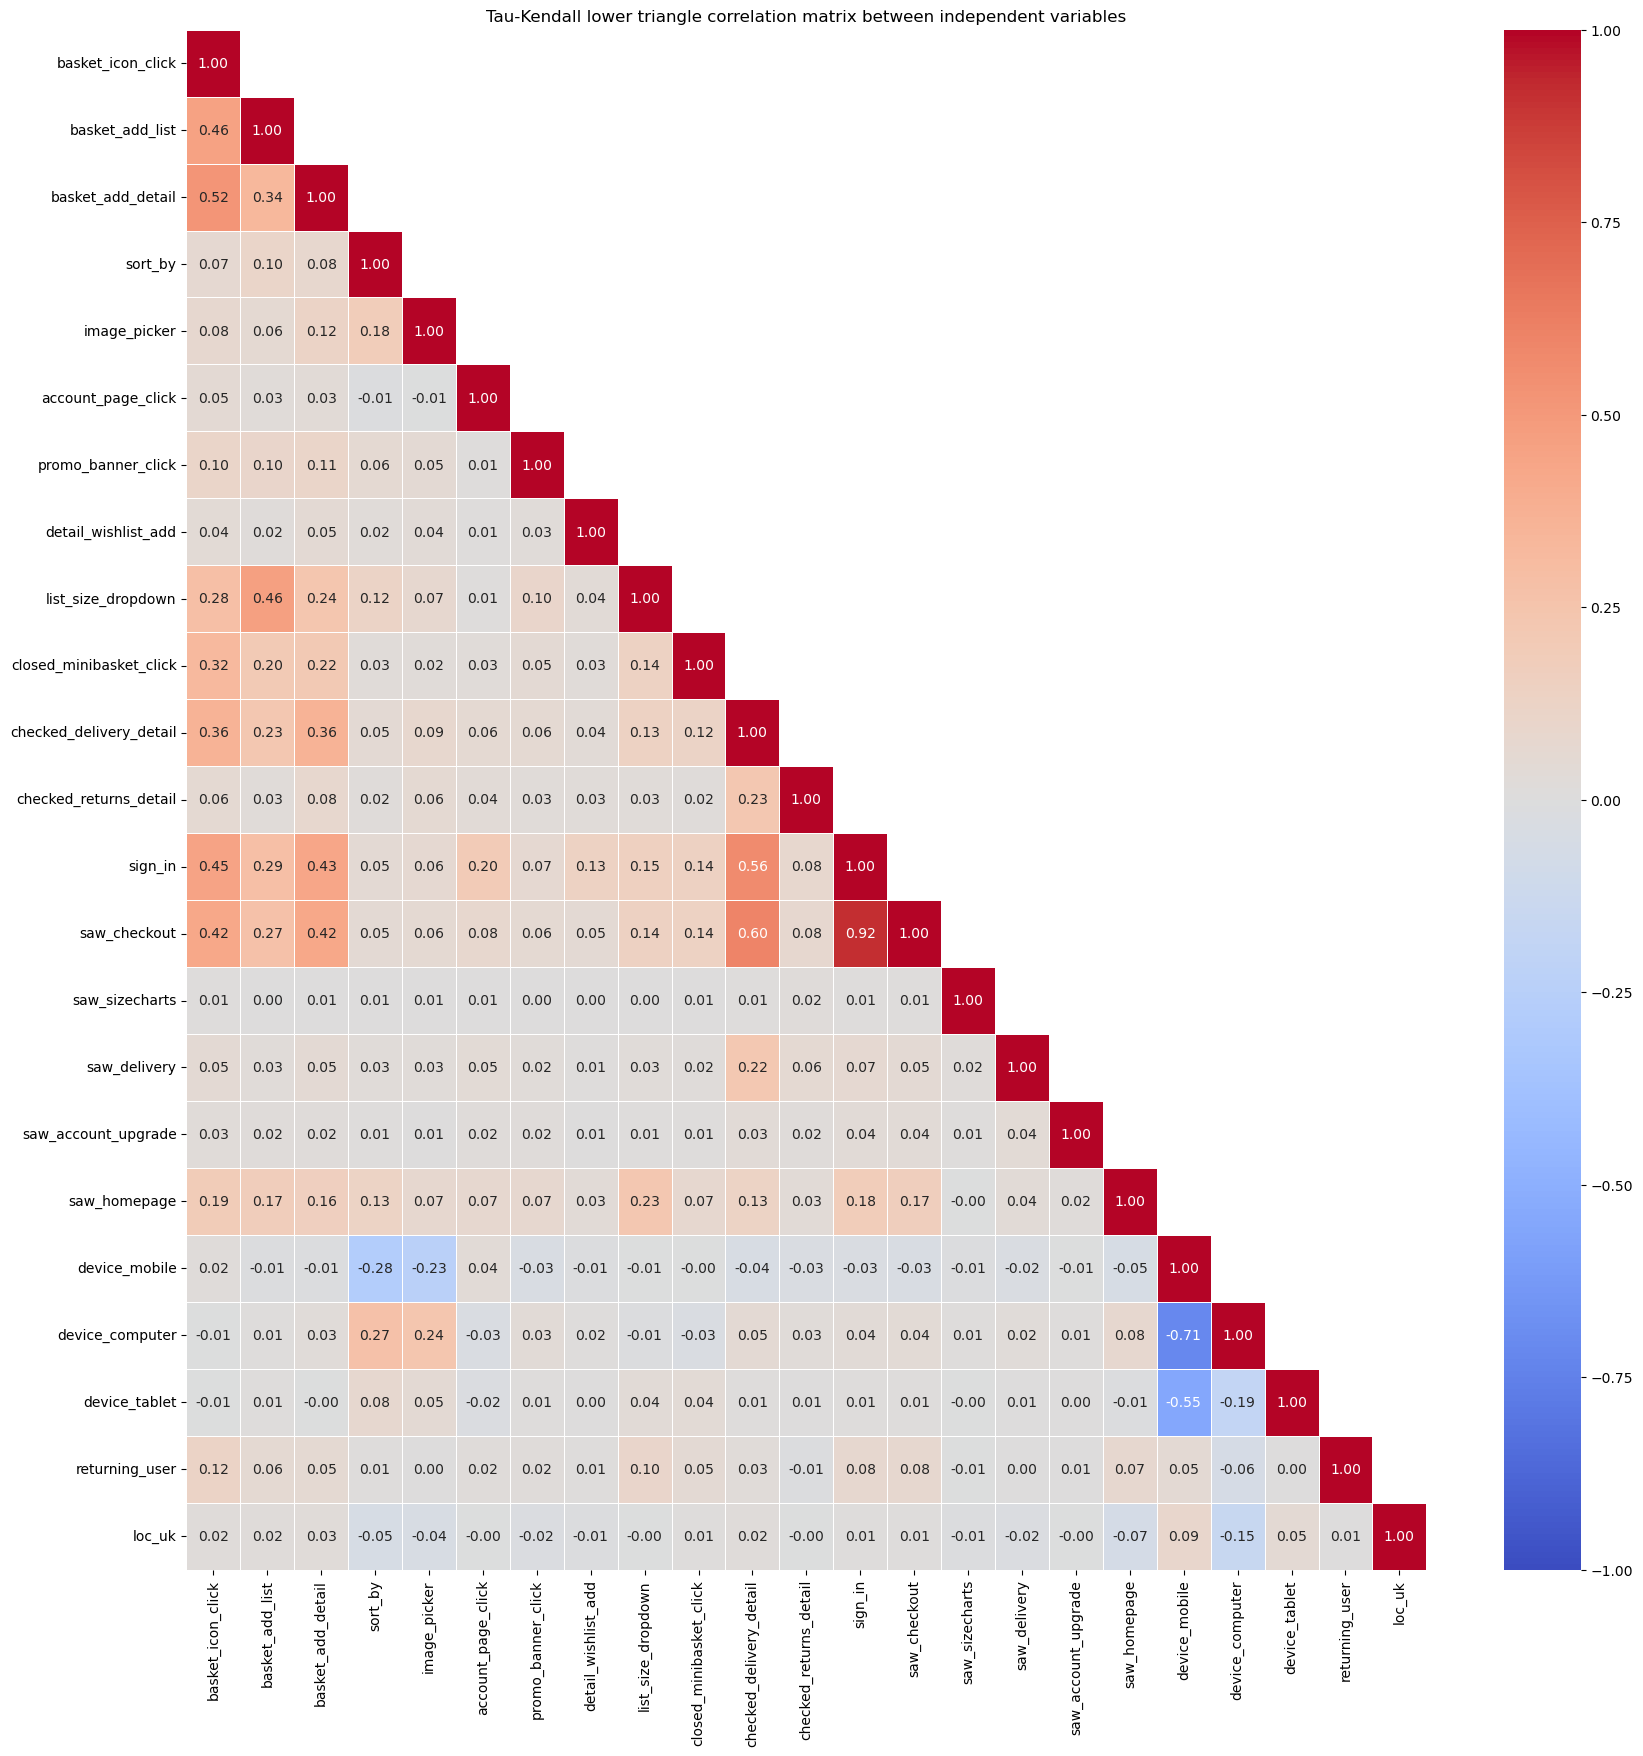

In [64]:
# correlation matrix for independent variable
ind_var_corr = df.iloc[:,:-1].corr(method='kendall')

# mask upper and lower triangle of independent variable correlation matrix
mask_upper = np.triu(np.ones(ind_var_corr.shape), k=1) # upper triangle mask created with np.triu (k=1 exclude diagonal)
mask_lower = np.tril(np.ones(ind_var_corr.shape), k=-1)  # lower triangle mask created with np.tril (k=-1 excludes diagonal)

# lower tiranlge of correlation matrix
cor_upper = ind_var_corr.where(mask_lower == 0)
corr_lower = ind_var_corr.where(mask_upper == 0)

# plotting heatmap for independent variable
plt.figure(figsize=(20,20))
sns.heatmap(corr_lower, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Tau-Kendall lower triangle correlation matrix between independent variables')
plt.show()


Let's filter the correlation outcomes to analyse only the features that are strongly correlated with each other. Treshold value will be 0.5 for positive correlation and -0.5 for negative correlation:

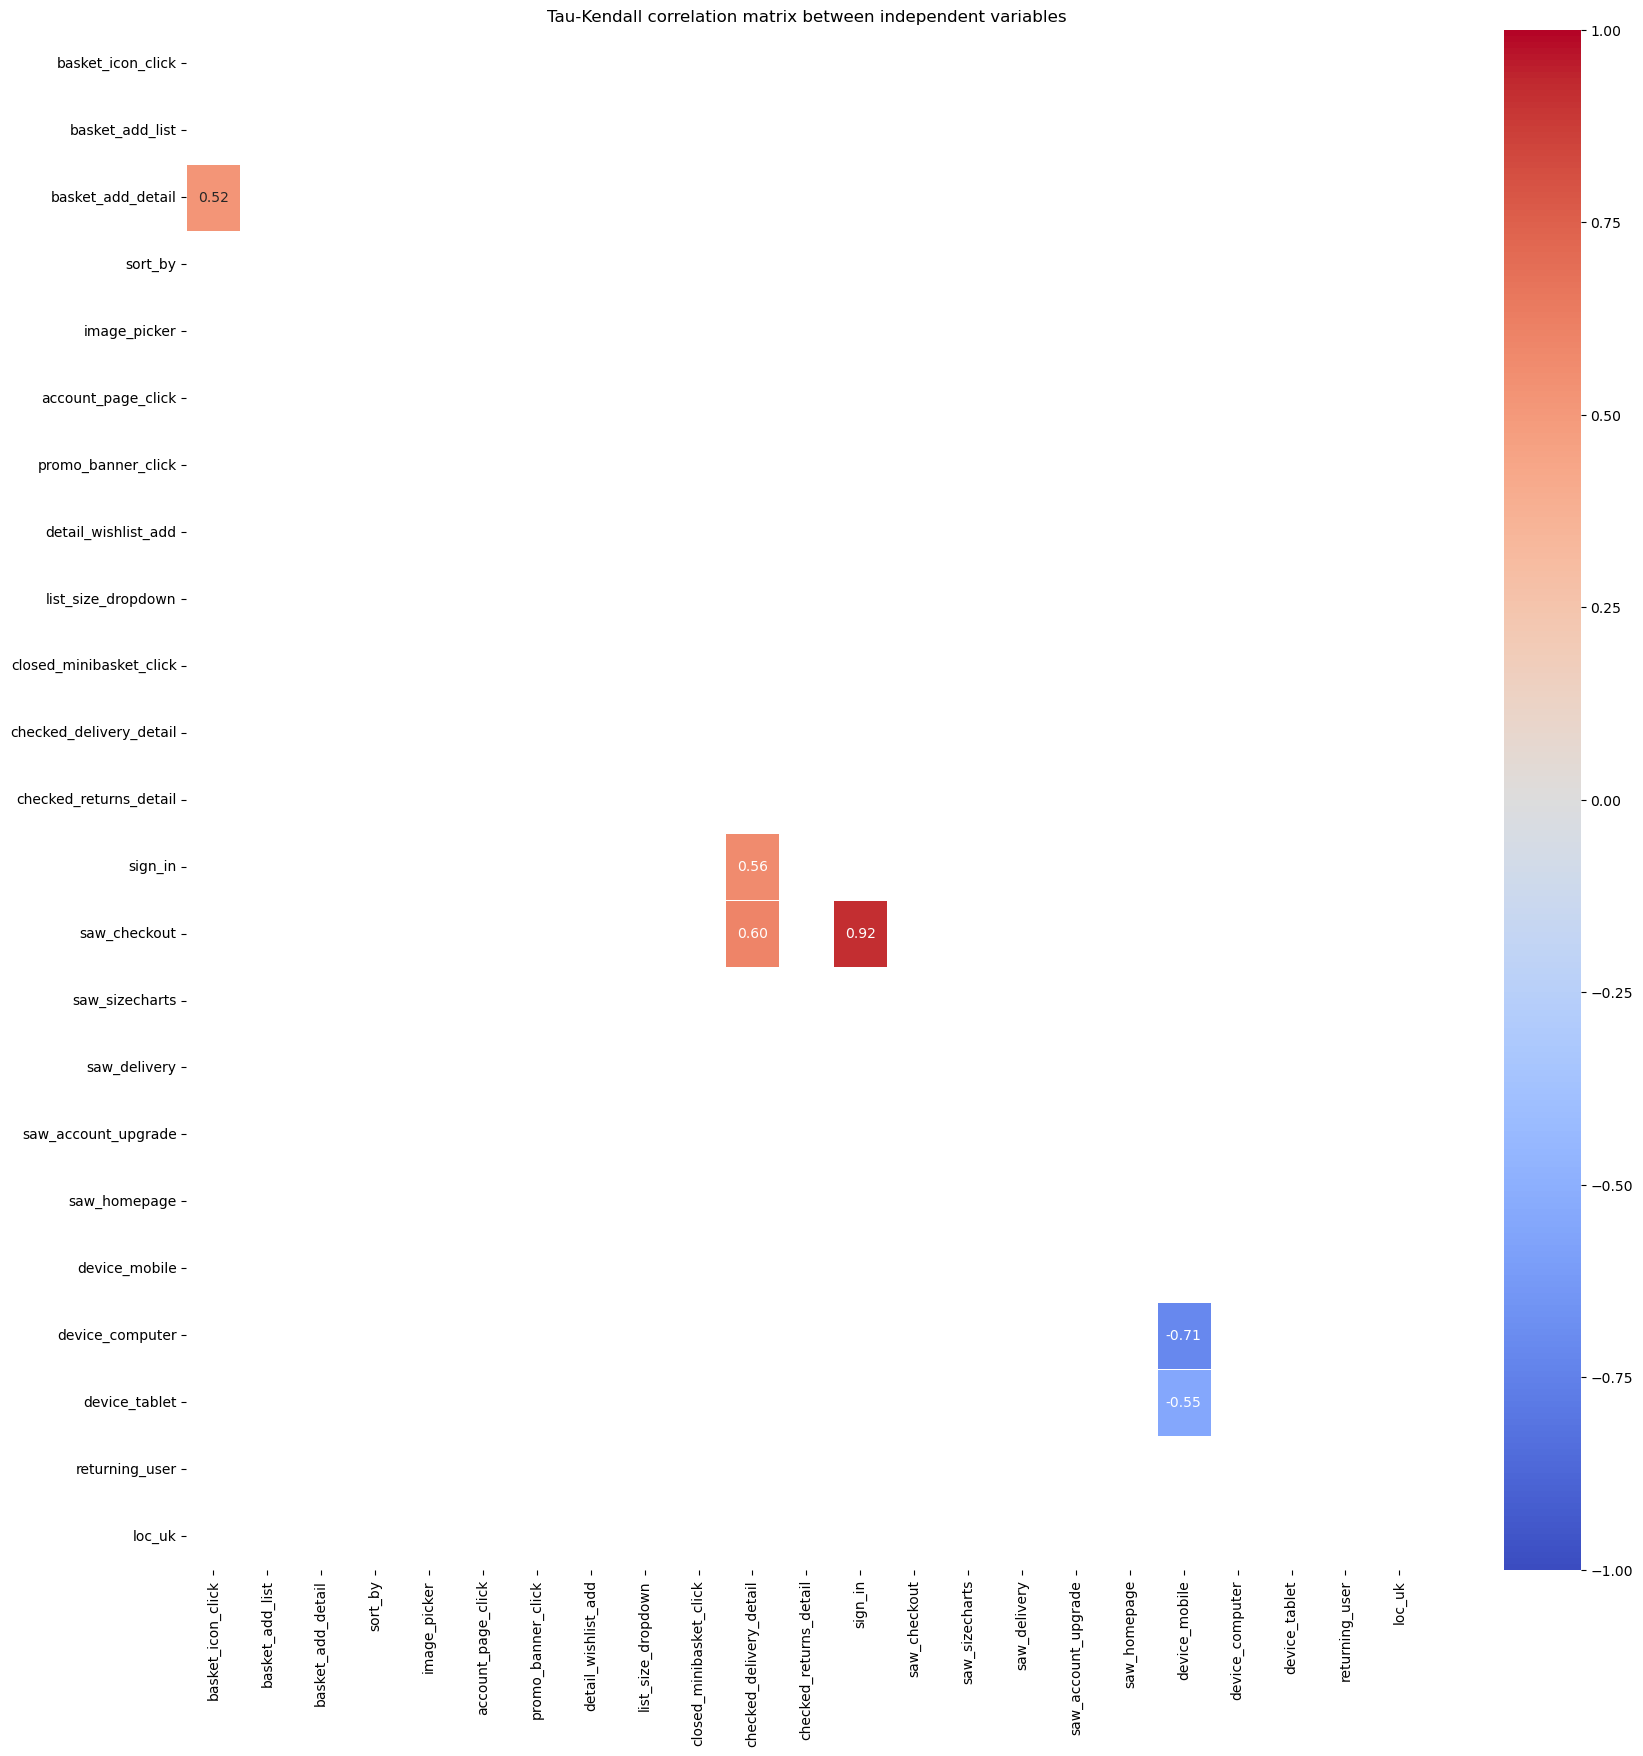

In [65]:
# leaving only correlations in range (-1 ; -0.5) or (0.5 ; 1)
strong_ind_var_corr = corr_lower[((corr_lower >= 0.5) & (corr_lower < 1)) | ((corr_lower > -1) & (corr_lower < -0.5)) ]
strong_ind_var_corr

# plotting strongly correlated independent variables
plt.figure(figsize=(20,20))
sns.heatmap(strong_ind_var_corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Tau-Kendall correlation matrix between independent variables')
plt.show()

We can observe strong positve correlation between independent variables for:
- basket_icon_click & basket_add_detail: 0.52
- checked_delivery_detail & sign_in: 0.56
- checked_delivery_detail & saw_checkout: 0.6
- sign_in & saw_checkout: 0.92

In turn, strong negative correlation pertains:
- device_mobile & device_computer: -0.71
- device_mobile & device_tablet: -0.55

Let's list these variables down for future comparisons:

In [66]:
strong_ind_var_corr_list = ['basket_icon_click','basket_add_detail','checked_delivery_detail',
                            'sign_in','saw_checkout','device_mobile','device_computer','device_tablet']

To exclude any of those we need to know which ones are correlated with target value. Beforehand let's see how all relations with target look:

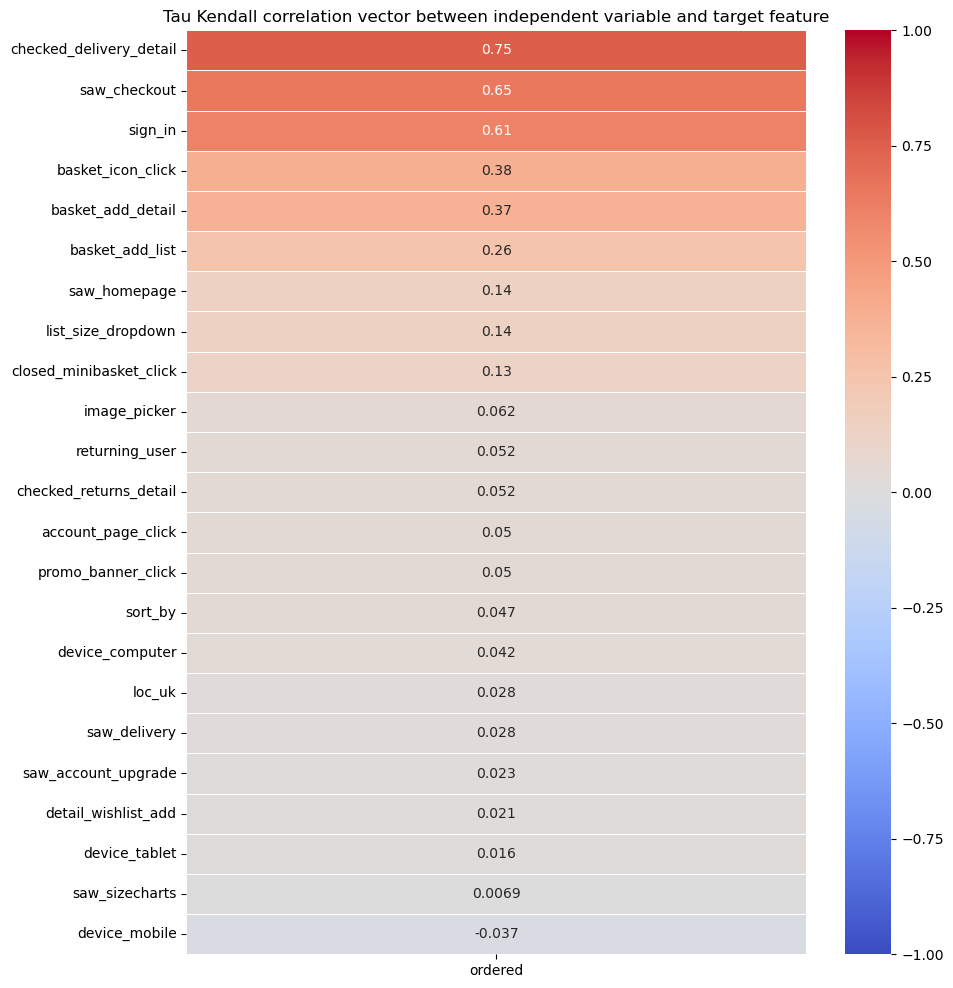

In [67]:
# correlation matrix for dependent variable
y_var_corr = df.corr(method='kendall')

# plotting heatmap for target variable sorted descdending
y_corr = y_var_corr[['ordered']].drop('ordered').sort_values(by='ordered', ascending=False)
plt.figure(figsize=(10,12))
sns.heatmap(y_corr, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Tau Kendall correlation vector between independent variable and target feature')
plt.show()

We set a treshold here on 0.05 and -0.05 (of course it's very weak correlation but some data that seems interesting and logical to take into account to modelling):

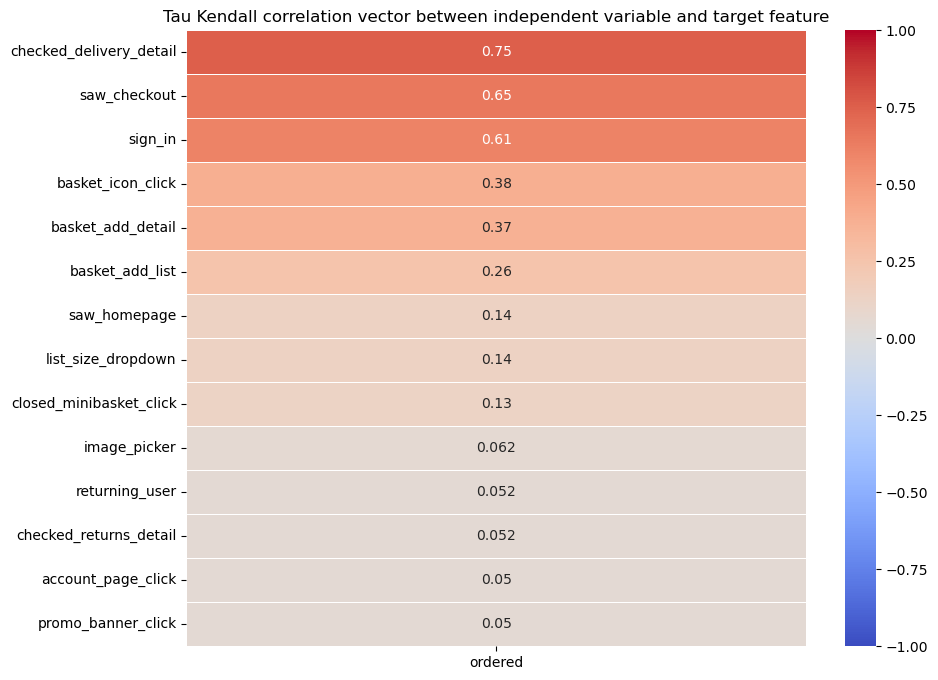

Number of independent variables correlated to some extend with target variable: 14


In [68]:
# variables correlated with target
signif_y_corr = y_corr[(y_corr > 0.05) | (y_corr < -0.05)].dropna()

# list of variables correlated to some extend with target
signif_y_corr_vars = list(signif_y_corr.index)

# plotting variables correlated with target
plt.figure(figsize=(10,8))
sns.heatmap(signif_y_corr, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Tau Kendall correlation vector between independent variable and target feature')
plt.show()
print(f'Number of independent variables correlated to some extend with target variable: {len(signif_y_corr_vars)}')

As we can see, there are 14 variables that according to strength of their correlation with ORDERED should be implemented in our model:
- check_delivery_detail: 0.75 - strong
- saw_checkout: 0.65 - strong
- sign_in: 0.61 - strong
- basket_icon_click: 0.38 - moderate
- basket_add_detail: 0.37 - moderate
- basket_add_list: 0.26 - weak
- saw_homepage: 0.14 - weak
- list_size_dropdown: 0.14 - weak
- closed_minibasekt_click: 0.13 - weak
- image_picker: 0.062 - very weak or no correlation
- returning_user: 0.052 - very weak or no correlation
- checked_returns_detail: 0.052 - very weak or no correlation
- account_page_click: 0.05 - very weak or no correlation
- promo_banner_click: 0.05 - very weak or no correlation

Now we can compare stongly correlated with each other independent variable to their correlation with target. 
If the first mentioned variables are not on the list of variables correlated to some extent with the target variable, we can exclude them from further analysis.

In [69]:
# dict of variables to cope with
var_to_decide = []
var_to_exclude = []

# loop checking if strongly correlated 
for var in strong_ind_var_corr_list:
    if var in signif_y_corr_vars:
        var_to_decide.append(var)
    else:
        var_to_exclude.append(var)

# glance at the results
print(f'Strongly correlated with each other independent variables to cope with: {var_to_decide}')
print(f'Strongly correlated with each other independent variables to exclude: {var_to_exclude}')


Strongly correlated with each other independent variables to cope with: ['basket_icon_click', 'basket_add_detail', 'checked_delivery_detail', 'sign_in', 'saw_checkout']
Strongly correlated with each other independent variables to exclude: ['device_mobile', 'device_computer', 'device_tablet']


There is no need to "fight" with device_mobile, device_computer and device_tablet - all of them will be excluded from dataset

Variables that creeate some problems are:
- basket_icon_click & basekt_add_detail: 
    - correlation with target respectively 0.38, 0.37;
    - correlation between them 0.52 - decision
- sign_in & saw_checkout: 
    - correlation with target respectively 0.61, 0.65;
    - correlation between them 0.92
- checked_delivery_detail & saw_checkout: 
    - correlation with target respectively 0.75, 0.65;
    - correlation between them 0.6
- checked_delivery_detail & sign_in: 
    - correlation with target respectively 0.75, 0.61; 
    - correlation between them 0.56

To make it easier to answer the question of what to do with the above variables, let's conduct the final analysis in this section – Information Value Analysis.



**Information Value (IV) Analysis** 

It's a statistical method used in machine learning and predictive modeling to evaluate the predictive power of independent variables with respect to a binary target variable. It quantifies how well a feature can separate the target classes (e.g., default vs. non-default in credit risk modeling) by comparing the distribution of the feature across the two classes. Features with high IV values are considered more informative, while those with very low IV values may be irrelevant or redundant for the model. The outcomes should be interpretted as followed:

Information Value |	Predictive Power                            
------------------|----------------------------------------------
|    < 0.02	      |      Useless                                |
|    0.02 - 0.1	  |      Weak                                   |
|    0.1 - 0.3	  |      Medium                                 |
|    0.3 - 0.5	  |      Strong                                 |
|    >0.5	      |      Suspiciously good; too good to be true |


Let's write function that will asses IV value for each of the 9 final considered variables:

In [70]:
# function to calculate Information Value and Weight of Evidence
# WoE = ln(Non_event_percentage/Event_percentage)
# IV = sigma(Event_percentage - Non_event_percentage) * WoE
# Event is probe when we have patient with one of our targeted diseases
# Non-event is probe when we have patient with one of our targeted diseases

def iv_calc(data: pd.DataFrame, target: str, bins=10, woe_show=True) -> pd.DataFrame:
    
    # Data frames to fill
    iv_df, woe_df = pd.DataFrame(), pd.DataFrame()
    
    # Independent variables list
    col_list = data.columns
    
    # WOE and IV calculation for each independent variable
    for col in col_list[~col_list.isin([target])]:
        if (data[col].dtype.kind in 'bifc') and (len(np.unique(data[col])) > 10):
            binned_x = pd.qcut(data[col], bins, duplicates='drop') # binned_x is to balance number of observation in each bin, so WoE wouldn't be biased
            d_temp = pd.DataFrame({'x': binned_x,
                                   'y': data[target]})
        else:
            d_temp = pd.DataFrame({'x': data[col],
                                   'y': data[target]})
            
        # Number of events in each group (bin)
        d = d_temp.groupby('x', as_index=False).agg({
            'y': ['count','sum']})
        d.columns = ['Cutoff', 'N', 'Events']
        
        # Percentage of events in each group (bin)
        d['Event_percentage'] = d['Events']/d['Events'].sum()
        
        # Non-events in each group (bin)
        d['Non_events'] = np.abs(d['N'] - d['Events'])
        # Non-events percentage in each group
        d['Non_event_percentage'] = d['Non_events']/d['Non_events'].sum()
        
        # WoE calculation 
        d['WoE'] = np.log(d['Event_percentage']/d['Non_event_percentage'])
        d['IV'] = d['WoE'] * (d['Event_percentage'] - d['Non_event_percentage'])
        d.insert(loc=0, column='Variable', value=col)
        tmp = pd.DataFrame({'Variable': [col],
                            'IV': [d['IV'].sum()]},
                            columns = ['Variable','IV'])
        iv_df = pd.concat([iv_df, tmp], axis=0)
        woe_df = pd.concat([woe_df, d], axis=0)
        
        # Whether to show WoE data frame
        if woe_show == True:
            print(woe_df)
    
    return iv_df, woe_df

IV calculations for our dataset:

In [71]:
# adding target value to signify_y_corr_vars list
signif_y_corr_vars.append('ordered')
signif_y_corr_vars_iv = signif_y_corr_vars

# dataset for calculations based on 9 final variables and target variable
df_to_iv = df.loc[:,df.columns.isin(signif_y_corr_vars_iv)]

# IV calculations
iv_results = iv_calc(data=df_to_iv, target='ordered', woe_show=False)
iv_results[0]

,Variable,IV
0,basket_icon_click,2.198408
0,basket_add_list,0.942903
0,basket_add_detail,2.235368
0,image_picker,0.072372
0,account_page_click,0.032778
0,promo_banner_click,0.045635
0,list_size_dropdown,0.473593
0,closed_minibasket_click,0.195469
0,checked_delivery_detail,8.059418
0,checked_returns_detail,0.042740


IV results of variables highly correlated with target are suspiciously good. It's quite often in such cases.

From variables weakly correlated with target, returning_user and maybe image_picker seems to have moderate use with predictive power closer to 0.1 than 0.02. At this point we can resign definitely from checked_returns_detail, account_page_click and promo_banner_click.

**Decisions based on correlation and information value analysis:**
- keeping basket_add_list - decent correlation score;
- keeping saw_homepage - weak correlation score but promising information value; 
- keeping list_size_dropdown - weak correlation but very promising information value;
- keeping closed_minibasekt_click - weak correlation but decent information value;
- keeping in dataset both basket_icon_click and basket_add_detail - correlation between these variables is strong but is closer to the lower boundary of the range indicating high correlation;
- keeping saw_checkout - in e-commerce checkout is the point in the shopping process where consumers finalize their purchases and pay. Despite higher correlation with checked_delivery_detail, it makes more sense to leave it rather than sign_in. When customer reaches a point of checkout, it is more probable that he will buy something because they're in the final stage of shopping process;
- exclusion of sign_in - its correlation with saw_checkout is too high and. Signing in on website itself doesn't have to indicate that client wants to buy somethon, it's only a first step in process of shopping;
- keeping checked_delivery_detail - it has the strongest correlation with our target. Viewing delivery FAQ section on a product page quite clearly points that client is eager or already decided they want to purchase it;
- keeping returning_user - very weak correlation but the outcome of information value indicates it may have some use;
- keeping image_picker - explenation as above;
- dropping out checked_returns_detail - very weak correlation and iv score;
- dropping out account_page_click - very weak correlation and iv score;
- dropping out promo_banner_click - very weak correlation and iv score;


**Eventually variables to use for modelling will be:**
- checked_delivery_detail;
- saw_checkout;
- basket_icon_click;
- basket_add_detail;
- basket_add_list;
- saw_homepage;
- list_size_dropdown;
- closed_minibasket_click;
- image_picker;
- returning_user.

**Summary of Data Preprocessing and EDA for Classification Model**

 - Data Type check: All variables except UserID (that feature won't be used to modelling) had integer type representing binary 0-1 values. Therefore, there was no need to convert data types.
 - Missing Data check: There are no missing values in dataset.
 - Duplicate check: The dataset and our business case are quite specific and limited in this regard. There is no variables that need to be checked for duplicates, as one customer can make multiple purchases at different times - if we have variables like transaction id and its timestamp, such a check would make more sense. Nevertheless, the duplicate verification for the UserID column did not reveal any duplicates. Therefore, no customer has placed an order more than once.
 - Outlier Detection and Correction: Because of the fact that we have only binary categorical values, outlier detection is unnecessary here.
 - Descripitve statistics and features variance of variables: All features exhibit a significant imbalance in the frequency of their categories. It vpulf ;be problematic especially with target variable which needs to be resampe before modelling with one of methods mentioned earlier: Random Undersampling, TomekLinks (undersample majority class methods), Random Oversampling, SMOTE, ADASYN (oversample minority class methods) or SMOTE-Tomek (combined approach of undersampling and undersampling). We will try ADASYN to verify if we have an improvement in model results.
 - Tau-Kendall Correlation Analysis results: Out of 23 considered features, only 9 exhibited correlation with target at level greater than 10% (check_delivery_detail: 75%; saw_checkout: 65%; sign_in: 61%; basket_icon_click: 38%; basket_add_detail: 37%; basket_add_list: 26%; saw_homepage: 14%;list_size_dropdown: 14%; closed_minibasekt_click: 13%). Some of them unfortunately are strongly correlated with each other like sign_in & saw_checkout (92%), checked_delivery_detail & saw_checkout (60%), checked_delivery_detail & sign_in (56%), basket_icon_click & basekt_add_detail (52%).
 - Information Value Analysis: IV analysis additionally indicated that the variables returning_user and image_picker might also have some predictive power.
 - Selection of variables based on correlation analysis and information value: Based on correlation and IV analysis, final set of independent variable includes: checked_delivery_detail, saw_checkout, basket_icon_click, basket_add_detail, basket_add_list, saw_homepage, list_size_dropdown, closed_minibasekt_click, image_picker, returning_user. Remaining variables either do not exhibit sufficient correlation or predictive power, or are too strongly correlated with variables better suited for our business case (e.g., sign_in which is strongly associated with saw_checkout).

**Key preprocessing/EDA steps included:**
 - Data cleaning: checking type of data and missing values, and outliers. 
 - Descriptive Statistics Analysis: crosstabs, percentage of occurances for features classes, modes.
 - Tau-Kendall Correlation Analysis of variables.
 - Information Value Analysis of variables.
 - Feature selection based on Correlation and Information Value analysis.

**Next steps:**
 - Removing of no longer needed attributes.
 - Splitting the data into training and testing sets.
 - Selecting and training various classification models.
 - Resampling minority class of target feature with methods mentioned above after first simple model.
 - Hyperparameter optimization.
 - Model evaluation and selection based on performance metrics.

 

**Data preperation for modelling**

Data frame with finally selected attributes for modelling:

In [72]:
# data frame with selected attributes
df_model = df[['checked_delivery_detail', 'saw_checkout', 'basket_icon_click', 'basket_add_detail', 'basket_add_list',
               'saw_homepage', 'list_size_dropdown', 'closed_minibasket_click', 'image_picker', 'returning_user', 'ordered']]

# glance at the results
df_model.head()

,checked_delivery_detail,saw_checkout,basket_icon_click,basket_add_detail,basket_add_list,saw_homepage,list_size_dropdown,closed_minibasket_click,image_picker,returning_user,ordered
0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,0
4,1,1,0,0,1,1,1,0,0,0,1


BEWARE! Notice that since all the variables we are using are binary, there is no need to standardize or scale them!

**Splitting the data into training and test split**

We're going to create 3 sets - train one, validation one and test one:

In [73]:
# defining matrix of independent features
X = df_model.iloc[:,:-1]
# defining vector of dependent variable
y = df_model.iloc[:,-1]

# train test split of df_model
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=25)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, train_size=0.5, random_state=25)

In [74]:
# checking if data split for y was succesfull
print(f'Number of all observations in y vector: {len(y)}')
print(f'Number of observations in y train vector: {len(y_train)}')
print(f'Number of observations in y validation vector: {len(y_val)}')
print(f'Number of observations in y test vector: {len(y_test)}')

print('Data split completed succesfully') if len(y) == len(y_train) + len(y_val) + len(y_test) else print('There was an error during data split')


Number of all observations in y vector: 607056
Number of observations in y train vector: 424939
Number of observations in y validation vector: 91058
Number of observations in y test vector: 91059
Data split completed succesfully


In [75]:
# checking if data split for X was succesfull
print(f'Number of all observations in X matrix: {len(X['basket_icon_click'])}')
print(f'Number of observations in X train matrix: {len(X_train['basket_icon_click'])}')
print(f'Number of observations in X validation matrix: {len(X_val['basket_icon_click'])}')
print(f'Number of observations in X test matrix: {len(X_test['basket_icon_click'])}')

print('Data split completed succesfully') if len(X['basket_icon_click']) == len(X_train['basket_icon_click']) + len(X_val['basket_icon_click']) + len(X_test['basket_icon_click']) else print('There was an error during data split')


Number of all observations in X matrix: 607056
Number of observations in X train matrix: 424939
Number of observations in X validation matrix: 91058
Number of observations in X test matrix: 91059
Data split completed succesfully


**Logistic Regression Model**

Logistic Regression model is a statistical method used for binary classification problems, predicting the probability of a categorical dependent variable based on minimum one independent variables. It applies the logistic function to map predicted values to a range between 0 and 1, enabling classification into distinct categories, such as 0 or 1.

Crucial aspect of model performance must be the most accurate classification of individuals who will place an order to focus on targeting them. We have metrics like recall (it represents the ratio of correctly identified elements of positive class to all its elements) or precision (it shows us how many observations indicated as positive class by our classifier, were actual from poitive class). But due to the fact that we are dealing with binary classification the appropriate evaluation metric is auc score. We want to receive model with its best result.


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     88213
           1       0.83      0.86      0.84      2845

    accuracy                           0.99     91058
   macro avg       0.91      0.93      0.92     91058
weighted avg       0.99      0.99      0.99     91058



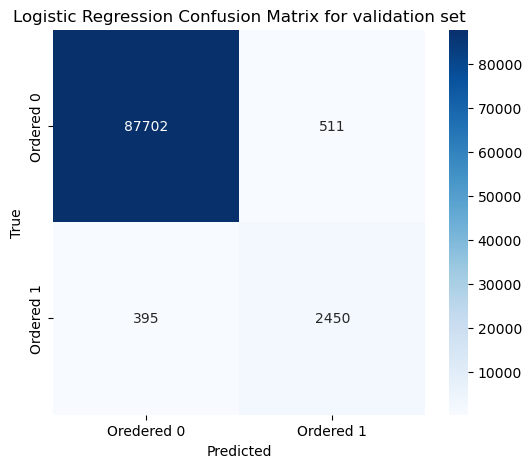

In [85]:
# create an instance of the LogisticRegression model
lr_model = LogisticRegression(random_state=25, solver='liblinear', C=0.001)

# fitting lr_model with X_train and y_train data
lr_model.fit(X_train, y_train)

# lr model prediction on X validation set
y_pred_val = lr_model.predict(X_val)  

# lr model evaluation on validation set
val_classrep = classification_report(y_val, y_pred_val)
val_cm = confusion_matrix(y_val, y_pred_val)

# glance at the results of prediction
print(f'\nClassification Report:\n {val_classrep}')

# plotting confusion matrix for validation set
plt.figure(figsize=(6, 5))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Oredered 0', 'Ordered 1'], yticklabels=['Ordered 0', 'Ordered 1'])
plt.title('Logistic Regression Confusion Matrix for validation set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**ROC Curve and AUC**

The ROC (Receiver Operating Characteristic) curve is a graphical representation that illustrates the trade-off between the true positive rate (sensitivity) and the false positive rate (1 - specificity) across different threshold values of a classification model. 

The AUC (Area Under the Curve) is a metric that quantifies the overall performance of the model, where a higher AUC indicates better ability to distinguish between classes, with a value of 1 representing perfect classification and 0.5 indicating random guessing.


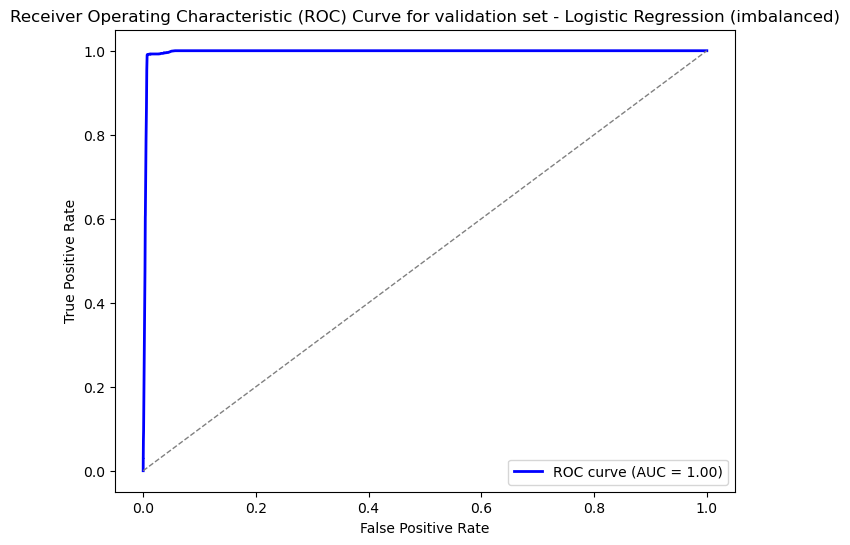

In [92]:
# getting probabilities for validation set
y_proba_val = lr_model.predict_proba(X_val)[:,1] # probabilities for psoitive class - Ordered 1

# calculation of ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_proba_val) # fpr - false positive rate = (1- specificity); tpr - true positive rate = sensitivity; 
roc_auc = roc_auc_score(y_val, y_proba_val)

# plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line (random classifier)
plt.title('Receiver Operating Characteristic (ROC) Curve for validation set - Logistic Regression (imbalanced)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

The outcomes of classification for validation set are suspiciously good: 
- almost perfect result for accuracy - 0.99 - model correctly predicts both classes. If both classes - positive and negative have a similar number of instances, and the model has high accuracy, it suggests that the model is performing very well. However, in our case this wouldn't necessarily indicate good performance because classes are not balanced;
- almost perfect results of recall of positive class - 0.99 - that means that 99% of observations in positive class were classified correctly;
- good result for precision of positive class - 0.82 - 82% af all observations predicted as positive class by model were in fact positive;
- perfect score for AUC - 1 - it shows us that simple Logistic Regression perfectly discriminates between positive and negative class on training set.

To decide whether our model is overfitted or not, we still need to check how it will generalize on the test set.


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     88189
           1       0.82      0.87      0.84      2870

    accuracy                           0.99     91059
   macro avg       0.91      0.93      0.92     91059
weighted avg       0.99      0.99      0.99     91059



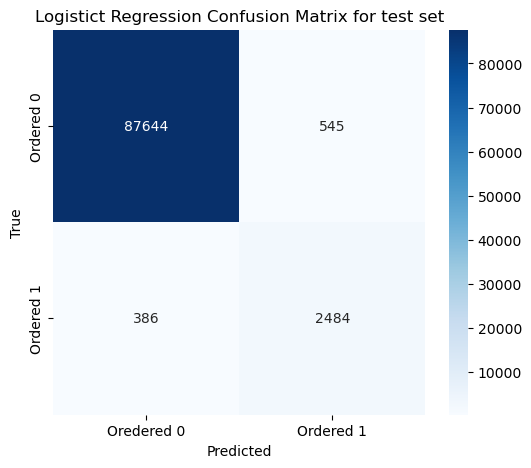

In [93]:
# lr model prediction with predict_proba on X test set

# BEWARE! We can use also predict_proba() 
# The predict() method would simply classify samples as 1 or 0 based on the default threshold of 0.5. 
# If we wanted to adjust the threshold, we're unable to do so directly using predict(), since it doesn't give us the probability information, only the final classification.
# With predict_proba(), we have more flexibility to make predictions based on any threshold that we choose.
y_proba_test = lr_model.predict_proba(X_test)[:,1] # probabilities for psoitive class - Ordered 1

# default treshold 0.5 on test set
threshold = 0.5
y_pred_test = (y_proba_test >= threshold).astype(int)

# lr model evaluation on validation set
test_classrep = classification_report(y_test, y_pred_test)
test_cm = confusion_matrix(y_test, y_pred_test)

# glance at the results of prediction
print(f'\nClassification Report:\n {test_classrep}')

# plotting confusion matrix for validation set
plt.figure(figsize=(6, 5))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Oredered 0', 'Ordered 1'], yticklabels=['Ordered 0', 'Ordered 1'])
plt.title('Logistict Regression Confusion Matrix for test set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


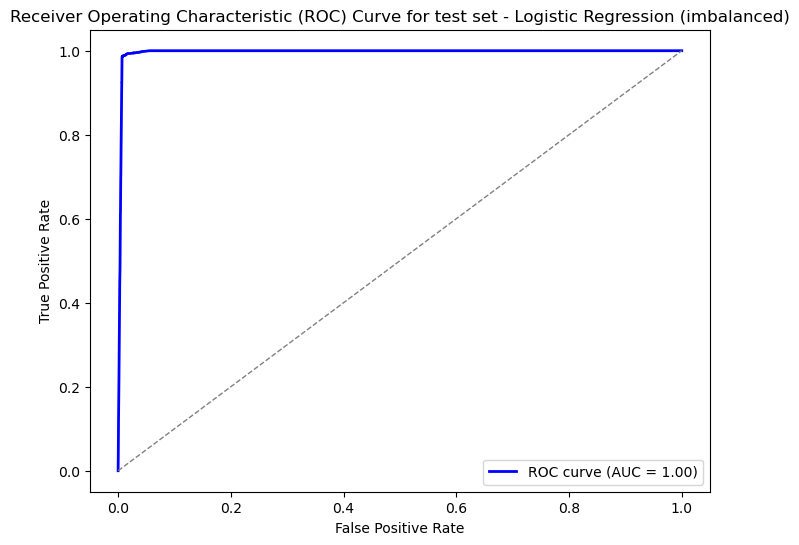

In [94]:
# getting probabilities for validation set
y_proba_test = lr_model.predict_proba(X_test)[:,1] # probabilities for psoitive class - Ordered 1

# calculation of ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test) # fpr - false positive rate = (1- specificity); tpr - true positive rate = sensitivity; 
roc_auc = roc_auc_score(y_test, y_proba_test)

# plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line (random classifier)
plt.title('Receiver Operating Characteristic (ROC) Curve for test set - Logistic Regression (imbalanced)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

Outcomes on test are almost identical as the ones on validation set (it's correct to notice here also that results are very good considering that our data are imbalanced, what could be problematic in classification problems). Therefore, we cannot conclude that our model is overfitted. Overfitting typically occurs when a model performs well on the training set but poorly on the test and validation set, meaning it has learned the details and noise in the training data to the extent that it negatively impacts its performance on new, unseen data.

This indicates that our Logistic Regression model generalizes well to both the training, validation, and test data. It suggests that the model performs consistently across different datasets which is quite surprising, knowing that our data are imbalanced.

Let's check at the end, if results of metrics will be similar for cross-validation with 5 folds with StratifiedKFolds which ensures that each fold will have a representative sample of classes:

In [ ]:
# initialize an instance of the Logistic Regression model
model = LogisticRegression(random_state=25)

# using StratifiedKFold to ensure class balance in each fold (important for binary classification)
k = 5
stratified_kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=25)

# perform k-fold cross-validation on various classification metrics
cv_acc_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='accuracy')
cv_rec_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='recall')
cv_prec_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='precision')
cv_f1_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='f1')
auc_scorer = make_scorer(roc_auc_score)
cv_auc_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring=auc_scorer)
cv_auc_scores = np.nan_to_num(cv_auc_scores, nan=0.5)

# print accuracy for each fold
print(f"Accuracy for each fold: {cv_acc_scores}")
# print average accuracy across all folds
print(f"Average accuracy: {np.mean(cv_acc_scores)}", '\n')

# print recall for each fold
print(f"Recall for each fold: {cv_rec_scores}")
# print average recall across all folds
print(f"Average recall: {np.mean(cv_rec_scores)}", '\n')

# print precision for each fold
print(f"Precision for each fold: {cv_prec_scores}")
# print average precision across all folds
print(f"Average precision: {np.mean(cv_prec_scores)}", '\n')

# print F1 score for each fold
print(f"F1 score for each fold: {cv_f1_scores}")
# print average F1 score across all folds
print(f"Average F1 score: {np.mean(cv_f1_scores)}", '\n')

# print AUC score for each fold
print(f"AUC score for each fold: {cv_auc_scores}")
# print average AUC score across all folds
print(f"Average AUC score: {np.mean(cv_auc_scores)}", '\n')


Accuracy for each fold: [0.99288373 0.99276013 0.99276013 0.99282602 0.99276013]
Average accuracy: 0.9927980283767786 

Recall for each fold: [0.98900236 0.99004715 0.98795181 0.9903116  0.99109715]
Average recall: 0.9896820109427772 

Precision for each fold: [0.82126549 0.81800476 0.81910966 0.81932409 0.8174946 ]
Average precision: 0.8190397214670518 

F1 score for each fold: [0.89736279 0.89584074 0.89564288 0.89673977 0.89596402]
Average F1 score: 0.8963100420357979 

AUC score for each fold: [0.99100607 0.99144768 0.99043403 0.99160964 0.99195564]
Average AUC score: 0.9912906119291011 



As w can see after simple rebalancing of classes with StratifiedKFold, Logistic Regression genrealizes very well both on training set and new data. It is proved by the outcomes of cross validation. We can expect AUC score at a level of 99%.

Possible reason of this could be the easiness of our problem - chosen features seem to be quite easy to classify, which results in high scores of metrics across all sets. 

**Random Forest Classifier**

A Random Forest classifier is an ensemble learning model that constructs multiple decision trees during training and outputs the class that is the majority vote of the trees for classification tasks. It helps reduce overfitting and increases accuracy by averaging multiple decision trees' results, improving robustness and generalization. The model is often used for classification tasks due to its ability to handle large datasets with high dimensionality.

Primary hyperparameters that can be optimized for a Random Forest binary classifier include:
- n_estimators - the number of trees in the forest, affecting the model’s accuracy and computation time.
- max_depth - the maximum depth of each tree, controlling model complexity and preventing overfitting.
- min_samples_split - the minimum number of samples required to split an internal node, influencing tree growth and overfitting.
- min_samples_leaf - the minimum number of samples required to be at a leaf node, helping control overfitting.
- max_features - the number of features to consider when looking for the best split, affecting both performance and computation time.
- bootstrap - whether to use bootstrap sampling (sampling with replacement) for training each tree.

We'll optimize hyperparameters with Optuna library here. Our target is to get the best f1 score result for positive class. Let's define objective function:

Best hyperparameters: {'n_estimators': 157, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     88189
           1       0.82      0.98      0.90      2870

    accuracy                           0.99     91059
   macro avg       0.91      0.99      0.95     91059
weighted avg       0.99      0.99      0.99     91059



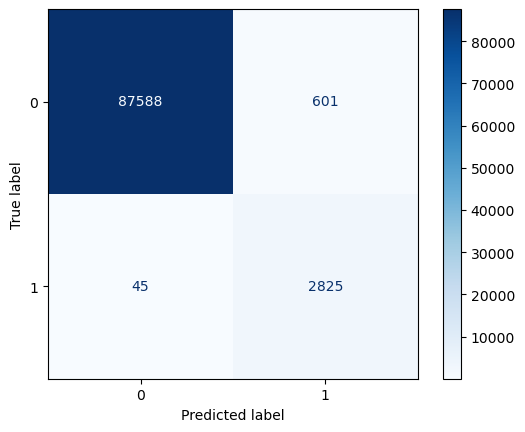

In [107]:
# disable all Optuna logs except critical errors
logging.getLogger("optuna").setLevel(logging.CRITICAL)

# define the objective function for Optuna
def objective(trial):
    # hyperparameters to optimize
    parameters = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200), # number of trees
        'max_depth': trial.suggest_int('max_depth', 2, 10), # max depth of each tree - be careful not to give maximum too huge!
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10), # min samples to split a node
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10), # min samples in a leaf node 
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']), # number of features to consider
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),  # whether to use bootstrap samples 
        'class_weight': 'balanced' # using 'balanced' to automatically adjust weights based on class frequencies
    }    

    # initialize the Random Forest classifier with the suggested hyperparameters
    rf_model = RandomForestClassifier(
        **parameters,
        random_state=42
    )
    
    # train the model on training set
    rf_model.fit(X_train, y_train)
    
    # probability predicition for X_test
    y_pred_proba = rf_model.predict_proba(X_test)[:,1]
    
    # auc score
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    # return auc score
    return auc_score
    
# creation of study and optimizing
study = optuna.create_study(direction='maximize', study_name="RandomForest Optimization")
study.optimize(objective, n_trials=10)  # perform 5 trials for hyperparameters optimization - it's not as much sources-consuming as SVM but I don't expect much improvement in the subsequent iterations 

# printing the best hyperparameters found by Optuna
print("Best hyperparameters:", study.best_params)

# Random Forest model fitting with the best hyperparameters found
best_rf_model = RandomForestClassifier(**study.best_params, random_state=25)
best_rf_model.fit(X_train, y_train)

# predict with optimized model
y_pred = best_rf_model.predict(X_test)

# model evaluation
rf_classrep = classification_report(y_test, y_pred)
print(f'\nClassification Report:\n {rf_classrep}')
rf_cm = confusion_matrix(y_test, y_pred)

# plotting confusion matrix for validation set
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")

ROC Curve and AUC score for Random Forest Classifier:

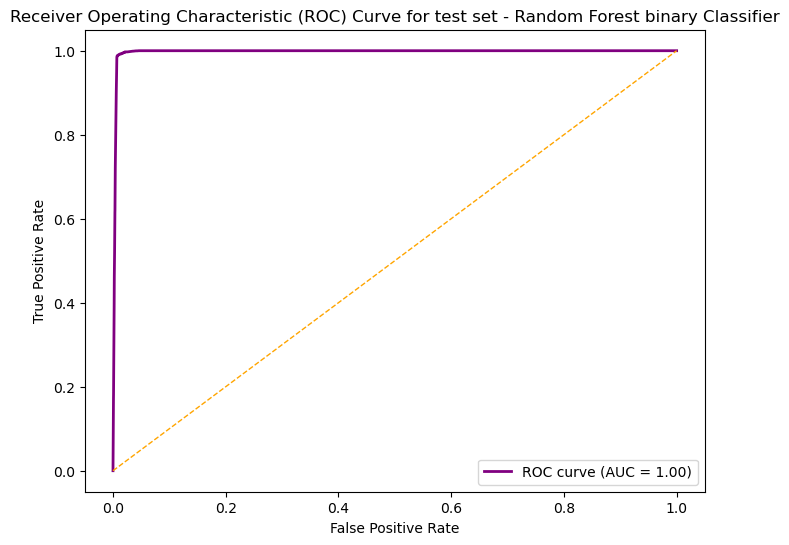

In [108]:
# getting probabilities for test set
y_proba = best_rf_model.predict_proba(X_test)[:, 1] # getting probabilities for positive class of target - Ordered 1

# computing ROC curve and AUC
fpr, tpr, treshold = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr) # alternative way to calculate auc by putting into this function false positive ratio and true positive ratio values 

# plotting ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='purple', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='orange', linestyle='--', lw=1) # diagonal line (random classifier)
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for test set - Random Forest binary Classifier')
plt.legend(loc='lower right')
plt.show()


The results for the Random Forest Classifier optimized with Optuna are the same as the ones of Logisitc Regreesion, especially f1 score of positive class: 
- accuracy - 0.99
- precision for positive class - 0.82
- recall for positive class - 0.98
- AUC score - 1

ROC curve and AUC score in this case also indicates that we have almost perfect classifier. Outcomes are almost the same as in the case of Logistic Regression model.

**CatBoost model**

CatBoost is a powerful gradient boosting algorithm specifically designed to handle categorical features efficiently, without the need for one-hot encoding, by using ordered target statistics.

The primary hyperparameters of the CatBoost model are:
- iterations - the number of boosting rounds (trees);
- learning_rate - The step size for each iteration;
- depth - the maximum depth of the trees;
- cat_features - indices or column names of categorical features;
- l2_leaf_reg - the L2 regularization coefficient to avoid overfitting;
- scale_pos_weight - adjusting imbalanced positive class

Best hyperparameters: {'iterations': 149, 'depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.09019933151105741, 'l2_leaf_reg': 4.529315509039479, 'scale_pos_weight': 9.620209684595293}
0:	learn: 0.6095431	total: 25.3ms	remaining: 3.74s
1:	learn: 0.5398190	total: 48.4ms	remaining: 3.56s
2:	learn: 0.4807591	total: 69ms	remaining: 3.36s
3:	learn: 0.4301394	total: 91.1ms	remaining: 3.3s
4:	learn: 0.3863840	total: 112ms	remaining: 3.23s
5:	learn: 0.3482487	total: 136ms	remaining: 3.24s
6:	learn: 0.3149430	total: 155ms	remaining: 3.15s
7:	learn: 0.2856009	total: 177ms	remaining: 3.12s
8:	learn: 0.2596235	total: 199ms	remaining: 3.1s
9:	learn: 0.2366566	total: 217ms	remaining: 3.02s
10:	learn: 0.2162532	total: 238ms	remaining: 2.98s
11:	learn: 0.1980594	total: 257ms	remaining: 2.94s
12:	learn: 0.1817852	total: 276ms	remaining: 2.89s
13:	learn: 0.1672037	total: 294ms	remaining: 2.83s
14:	learn: 0.1541531	total: 310ms	remaining: 2.77s
15:	learn: 0.1424228	total: 330ms	remaining: 2.74s
16:	le

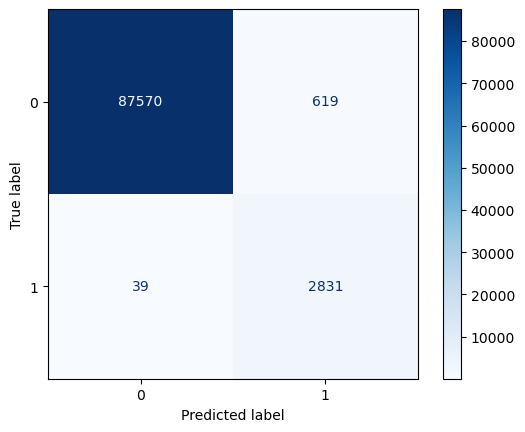

In [115]:
# disable all Optuna logs except critical errors
logging.getLogger("optuna").setLevel(logging.CRITICAL)

# defining the objective function for Optuna optimization
def objective(trial):
    # define hyperparameters to tune
    param = {
            'iterations': trial.suggest_int('iterations', 50, 200), # number of boosting iterations/trees
            'depth': trial.suggest_int('depth', 2, 10), # depth of each tree 
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20), # minimum number of samples in a leaf
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log = True), # learning rate on logarithmic cale for better exploration of small values
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10), # L2 regularization coefficient to control overfitting
            # scale positive weight works only for binary classification
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 15.0), # weight to adjust for class imbalance
            'verbose': 0 # suppress output
        }
    
    # CatBoostClassifier creation with the current set of hyperparameters
    catboost_model = CatBoostClassifier(
        **param,
        loss_function = 'Logloss',
        eval_metric = 'AUC',
        random_seed = 25
        )
    
    # train the model
    catboost_model.fit(X_train, y_train)
    
    # probability predicition for X_test
    y_pred_proba = catboost_model.predict_proba(X_test)[:,1]
    
    # auc score
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    # return auc score
    return auc_score
    
# running Optuna optimization to find the best hyperparameters
study = optuna.create_study(direction='maximize', study_name="CatBoost Optimization")
study.optimize(objective, n_trials=10) # We can increase the number of trial to let's say 10 here, due to the fact that we have gradient boosting algorithm

# printing the best hyperparameters found by Optuna
print('Best hyperparameters:', study.best_params)

# model training with the best hyperparameters
best_params = study.best_params
best_cb_model = CatBoostClassifier(**best_params, random_state=25)
best_cb_model.fit(X_train, y_train)

# classification report
y_pred = best_cb_model.predict(X_test)
catboost_classrep = classification_report(y_test, y_pred)
print('\nClassification Report:\n', catboost_classrep)

# confusion matrix  
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")

ROC Curve and AUC score for CatBoost Classifier:

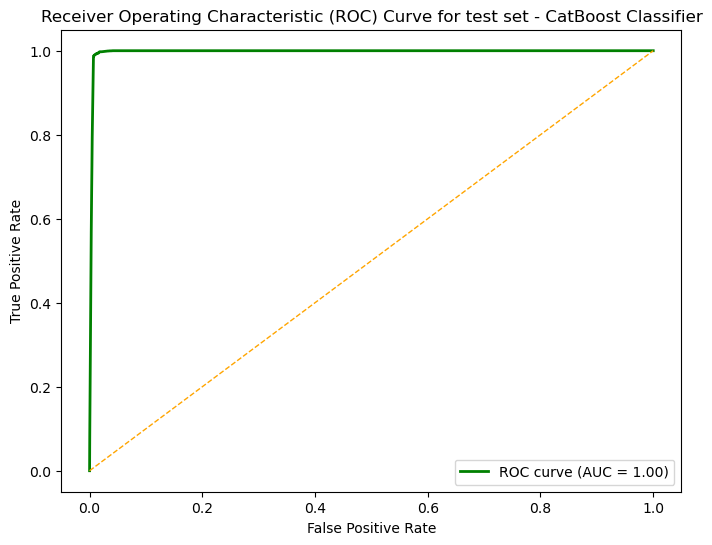

In [116]:
# getting probabilities for test set
y_proba = best_cb_model.predict_proba(X_test)[:, 1] # getting probabilities for positive class of target - Ordered 1

# computing ROC curve and AUC
fpr, tpr, treshold = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr) # alternative way to calculate auc by putting into this function false positive ratio and true positive ratio values 

# plotting ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='orange', linestyle='--', lw=1) # diagonal line (random classifier)
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for test set - CatBoost Classifier')
plt.legend(loc='lower right')
plt.show()

The results for the CatBoost Classifier optimized with Optuna are: 
- accuracy - 0.99
- precision for positive class - 0.82
- recall for positive class - 0.99
- AUC score - 1

ROC curve and AUC score in this case also indicates that we have almost perfect classifier. Outcomes here are the same as of Logistic Regression model and Random Forest Classifier.

**LightGBM (Light Gradient Boosting Machine) model**

LightGBM (Light Gradient Boosting Machine) is an efficient gradient boosting framework that is designed to handle large datasets with high-dimensional features, using histogram-based algorithms for faster training. It supports both categorical features natively and offers a variety of optimizations for speed, such as leaf-wise tree growth and the ability to work with sparse data. 

The primary hyperparameters include:
- num_leaves - the number of leaves in each tree;
- learning_rate - controls the contribution of each tree;
- max_depth - maximum depth of the tree;
- n_estimators - number of boosting rounds;
- boosting_type - type of boosting, such as 'gbdt' or 'dart'.

Best hyperparameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'learning_rate': 0.2956655514363469, 'n_estimators': 159, 'max_depth': 3, 'scale_pos_weight': 9.158820713050021}

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     88189
           1       0.82      0.99      0.90      2870

    accuracy                           0.99     91059
   macro avg       0.91      0.99      0.95     91059
weighted avg       0.99      0.99      0.99     91059



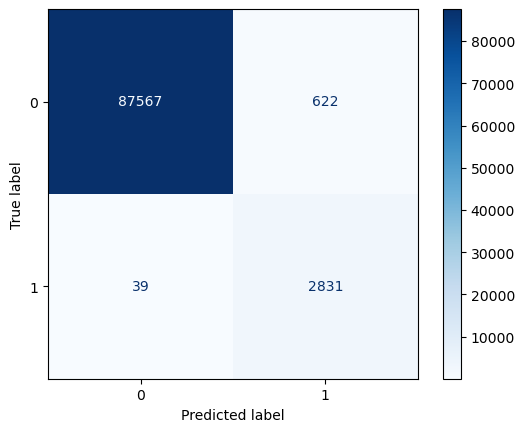

In [119]:
# disable all Optuna logs except critical errors
logging.getLogger("optuna").setLevel(logging.CRITICAL)

# define the objective function for Optuna optimization
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'f1',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 15.0), # weight to adjust for class imbalance
        'verbosity': -1 # supress outputs
    }

    # training the model using LGBMClassifier instead of lgb.train
    model = lgb.LGBMClassifier(**param, random_state=42)

    # training the model
    model.fit(X_train, y_train)

    # predict probabilities on the test set
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for class 1
    
    # AUC score
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # return the F1 score as the objective
    return auc_score

# running Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # We can increase the number of trial to let's say 10 here, due to the fact that we have gradient boosting algorithm

# print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# fitting model with the best hyperparameters
best_params = study.best_params
best_lgb_model = lgb.LGBMClassifier(**best_params, random_state=25)
best_lgb_model.fit(X_train, y_train)

# classification Report
y_pred = best_lgb_model.predict(X_test)
lgb_classrep = classification_report(y_test, y_pred)
print("\nClassification Report:\n", lgb_classrep)

# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")

ROC Curve and AUC score for CatBoost Classifier:

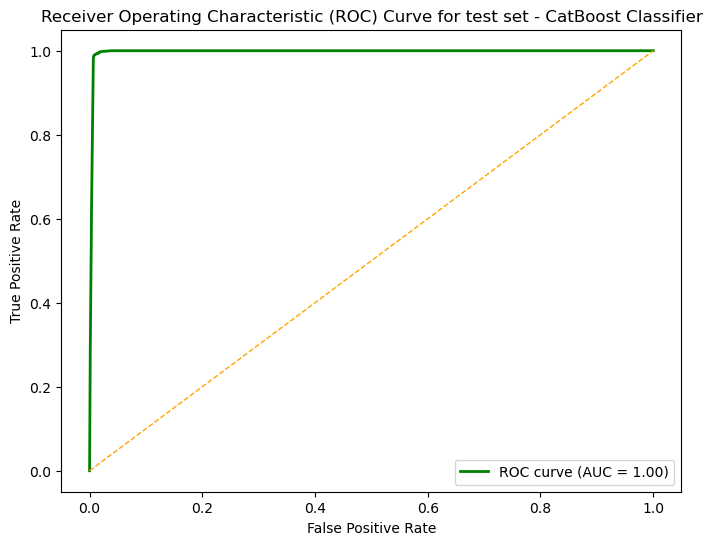

In [120]:
# getting probabilities for test set
y_proba = best_lgb_model.predict_proba(X_test)[:, 1] # getting probabilities for positive class of target - Ordered 1

# computing ROC curve and AUC
fpr, tpr, treshold = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr) # alternative way to calculate auc by putting into this function false positive ratio and true positive ratio values 

# plotting ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='orange', linestyle='--', lw=1) # diagonal line (random classifier)
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for test set - CatBoost Classifier')
plt.legend(loc='lower right')
plt.show()

The results for the LightGBM Classifier optimized with Optuna are: 
- accuracy - 0.99
- precision for positive class - 0.82
- recall for positive class - 0.99
- AUC score - 1

ROC curve and AUC score once more indicates that we have almost perfect classifier. Results are the same as the ones of the previous models


**Modelling Section Summary**

Evaluated models include:
- Logistic Regression
- Random Forest binary Classifier optimized with Optuna
- CatBoost binary Classifier optimized with Optuna
- Light GBM Classifier optimized with Optuna

In general all trained models have essentially identical outcomes of metrics, generalize excellently on new unseen data and they could successfully be used in practical applications. What's the most unexcpected we are not dealing here with overfitting, as the results on the test set are as good as the ones on the training set (slightly lower).

It doesn't seem to be caused by data leakage or some kind of error during data split. As I mentioned before the cause could be too easy to classify data - in such cases model may achieve very high results on both sets. This could be the case when the classification problem is too simple or the data is very well separated.

Let's stick with CatBoost Classifier that has greater flexibility in working with data, particularly with categorical data (all our variables), and can handle non-standard relationships between features more effectively. However, if one prefers simplicity, interpretability, and speed (especially with large datasets), logistic regression might be the better choice.

Now we'll check out the contribution and influance of each feature used for prediction. For this purpose we'll use feature importance - it measures the relative contribution of each feature to a model's predictions, helping identify which features have the most influence on the outcome.


Feature Importance:
                           Feature  Importance
1             Feature saw_checkout   49.554399
0  Feature checked_delivery_detail   35.786280
3        Feature basket_add_detail    2.980377
9           Feature returning_user    2.572191
2        Feature basket_icon_click    2.261247
6       Feature list_size_dropdown    1.965776
4          Feature basket_add_list    1.790400
5             Feature saw_homepage    1.223236
8             Feature image_picker    1.153382
7  Feature closed_minibasket_click    0.712711


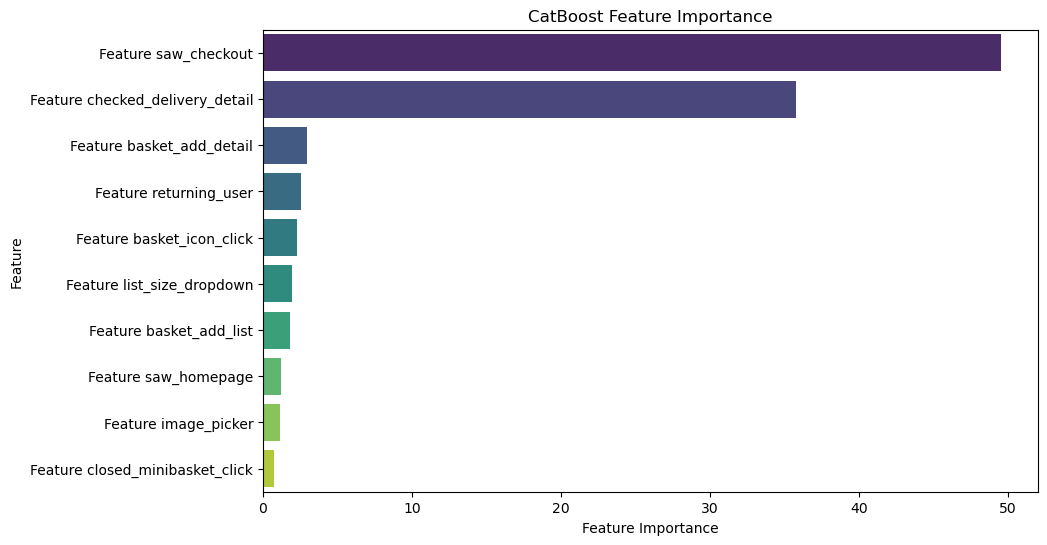

In [ ]:
# feature names list
feature_names = [f'Feature {el}' for el in X.columns]

# feature importance of CatBoost Classifier
feature_importance = best_cb_model.get_feature_importance(Pool(X_train, label=y_train))
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importance:")
print(importance_df)

# feature importance plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance' , y='Feature', palette='viridis', orient='h')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("CatBoost Feature Importance")
plt.show()

**CatBoost Classifiter explainability**

Most important independent variables are saw_checkout, checked_delivery_detail - they explain nearly 86% of the variability of the studied case with importance respectively equal to 50% and 36%. In turn, the least important independent variables is closed_minibascket_click which doesn't have even 1% of importance, not much more have image_picker and saw_homepage (1% in round figures).

It seems if client viewed the delivery FAQ section on a product page (checked_delivery_detail) and viewed the checkout (saw_checkout), then we are dealing with a customer who is about to make a purchase on our platform sooner or later.

**Recommendations**

A group of customers characterized by the above acitivities, right after passing to the FAQ section on the product page, should be informed in a small pop-up window about additional promotions, other products they may be interested in, or potential discounts available if they decide to add another product to their basket. This action should temporarily minimize the risk of basket abandonment. In the longer term, however, the company should consider creating an efficient communication system for this group of customers, as well as a loyalty program offering them additional bonuses and discounts. Key components of this strategy should be contacting via an e-mail and/or phone cell texting.
